# Task One -- Sentiment Analysis (FiQA SA)

## Importing Packages for Part One

In [1]:
from datasets import load_dataset # Doesn't work on PyCharm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import reprlib

import numpy as np
import matplotlib.pyplot as plt
import json

ModuleNotFoundError: No module named 'datasets'

## Importing the Training Files

In [ ]:
train_files = ["data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json",
               "data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json"]

In [231]:
def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, "r", encoding="utf-8") as handle:  # UTF-8 is needed to prevent a UnicodeDecodeError it caused
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f"Number of instances: {len(all_text)}")
print(f"Number of labels: {len(all_labels)}")

all_labels = threshold_scores(all_labels)
print(f"Number of negative labels: {np.sum(all_labels==0)}")
print(f"Number of neutral labels: {np.sum(all_labels==1)}")
print(f"Number of positive labels: {np.sum(all_labels==2)}")

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


## Creating the Test Split

In [232]:
# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels)  # make sure the same proportion of labels is in the test set and training set

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels)  # make sure the same proportion of labels is in the test set and training set

print(f"Number of training instances = {len(train_documents)}")
print(f"Number of validation instances = {len(val_documents)}")
print(f"Number of test instances = {len(test_documents)}")

print(f"\nWhat does one instance look like from the training set?:\n{train_documents[234]}")
print(f"...and here is its corresponding sentiment label: {train_labels[234]}")

Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223

What does one instance look like from the training set?:
$AMCN pushing highs
...and here is its corresponding sentiment label: 2


## Preprocessing the Data

### Tokenizing, Stop Word Removal, Case Folding, and Lemmatisation

In [233]:
# import nltk
# nltk.download('omw-1.4')
# nltk.download('stopwords')

In [234]:
# Define the stop words
stopwords_list = stopwords.words("english")

class LemmaTokenizer(object):
    def __call__(self, documents):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(documents)]
    
vectorizer_Lem = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')

vectorizer_Lem.fit(train_documents)  # Learn the vocabulary
X_train_Lem = vectorizer_Lem.transform(train_documents) # extract training set bags of words
X_val_Lem = vectorizer_Lem.transform(val_documents) # extract validation set bags of words
X_test_Lem = vectorizer_Lem.transform(test_documents)  # extract test set bags of words

C:\Users\misha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\misha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [235]:
vocabulary_Lem = vectorizer_Lem.vocabulary_
print(f"Vocabulary size = {len(vocabulary)}")

Vocabulary size = 2684


### Tokenizing, Stop Word Removal, Case Folding, and no Lemmatisation

In [236]:
# Define the stop words
stopwords_list = stopwords.words("english")

class Tokenizer(object):
    def __call__(self, documents):
        return word_tokenize(documents.lower())

vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words='english')

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents) # extract training set bags of words
X_val = vectorizer.transform(val_documents) # extract validation set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

## Applying Naive Bayes to Lem set

In [237]:
# Defining the classifier
classifier_Lem = MultinomialNB()

# Training the classifier
classifier_Lem.fit(X_train_Lem, train_labels)

MultinomialNB()

In [238]:
# Testing the classifier
y_val_pred_Lem = classifier_Lem.predict(X_val_Lem)

In [243]:
acc_lem = accuracy_score(val_labels, y_val_pred_Lem)
print(f'Accuracy = {acc_lem}')

prec_lem = precision_score(val_labels, y_val_pred_Lem, average='macro')
print(f'Precision (macro average) = {prec_lem}')

rec_lem = recall_score(val_labels, y_val_pred_Lem, average='macro')
print(f'Recall (macro average) = {rec_lem}')

f1_micro_lem = f1_score(val_labels, y_val_pred_Lem, average='micro')
print(f'F1 score (micro average) = {f1_micro_lem}')

f1_macro_lem = f1_score(val_labels, y_val_pred_Lem, average='macro')
print(f'F1 score (macro average) = {f1_macro_lem}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred_Lem))

Accuracy = 0.6492537313432836
Precision (macro average) = 0.6773448773448774
Recall (macro average) = 0.5251552922785799
F1 score (micro average) = 0.6492537313432836
F1 score (macro average) = 0.5487718274235128
              precision    recall  f1-score   support

           0       0.67      0.32      0.44        37
           1       0.73      0.33      0.46        24
           2       0.64      0.92      0.75        73

    accuracy                           0.65       134
   macro avg       0.68      0.53      0.55       134
weighted avg       0.66      0.65      0.61       134



## Applying Naive Bayes to non Lem set

In [240]:
# Defining the classifier
classifier = MultinomialNB()

# Training the classifier
classifier.fit(X_train, train_labels)

MultinomialNB()

In [241]:
# Testing the classifier
y_val_pred = classifier.predict(X_val)

In [242]:
acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1_micro = f1_score(val_labels, y_val_pred, average='micro')
print(f'F1 score (micro average) = {f1_micro}')

f1_macro = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1_macro}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.664179104477612
Precision (macro average) = 0.6846153846153845
Recall (macro average) = 0.5484902710930109
F1 score (micro average) = 0.664179104477612
F1 score (macro average) = 0.56808633927278
              precision    recall  f1-score   support

           0       0.73      0.30      0.42        37
           1       0.67      0.42      0.51        24
           2       0.65      0.93      0.77        73

    accuracy                           0.66       134
   macro avg       0.68      0.55      0.57       134
weighted avg       0.68      0.66      0.63       134



## Applying Logistic Regression to Lem set

In [258]:
# Defining the classifier
logi_classifier_Lem = LogisticRegression()

# Training the classifier
logi_classifier_Lem.fit(X_train_Lem, train_labels)

LogisticRegression()

In [259]:
# Testing the classifier
y_val_pred_logi_Lem = logi_classifier_Lem.predict(X_val_Lem)

In [260]:
acc_logi_lem = accuracy_score(val_labels, y_val_pred_logi_Lem)
print(f'Accuracy = {acc_logi_lem}')

prec_logi_lem = precision_score(val_labels, y_val_pred_logi_Lem, average='macro')
print(f'Precision (macro average) = {prec_logi_lem}')

rec_logi_lem = recall_score(val_labels, y_val_pred_logi_Lem, average='macro')
print(f'Recall (macro average) = {rec_logi_lem}')

f1_micro_logi_lem = f1_score(val_labels, y_val_pred_logi_Lem, average='micro')
print(f'F1 score (micro average) = {f1_micro_logi_lem}')

f1_macro_logi_lem = f1_score(val_labels, y_val_pred_logi_Lem, average='macro')
print(f'F1 score (macro average) = {f1_macro_logi_lem}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred_logi_Lem))

Accuracy = 0.6940298507462687
Precision (macro average) = 0.7155448717948718
Recall (macro average) = 0.5889691060923937
F1 score (micro average) = 0.6940298507462687
F1 score (macro average) = 0.6187971572586957
              precision    recall  f1-score   support

           0       0.62      0.43      0.51        37
           1       0.83      0.42      0.56        24
           2       0.70      0.92      0.79        73

    accuracy                           0.69       134
   macro avg       0.72      0.59      0.62       134
weighted avg       0.70      0.69      0.67       134



## Applying Logistic Regression to non Lem set

In [266]:
# Defining the classifier
logi_classifier = LogisticRegression()

# Training the classifier
logi_classifier.fit(X_train, train_labels)

LogisticRegression()

In [267]:
# Testing the classifier
y_val_pred_logi = logi_classifier.predict(X_val)

In [268]:
acc_logi = accuracy_score(val_labels, y_val_pred_logi)
print(f'Accuracy = {acc_logi}')

prec_logi = precision_score(val_labels, y_val_pred_logi, average='macro')
print(f'Precision (macro average) = {prec_logi}')

rec_logi = recall_score(val_labels, y_val_pred_logi, average='macro')
print(f'Recall (macro average) = {rec_logi}')

f1_micro_logi = f1_score(val_labels, y_val_pred_logi, average='micro')
print(f'F1 score (micro average) = {f1_micro_logi}')

f1_macro_logi = f1_score(val_labels, y_val_pred_logi, average='macro')
print(f'F1 score (macro average) = {f1_macro_logi}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred_logi))

Accuracy = 0.6492537313432836
Precision (macro average) = 0.6452791195059236
Recall (macro average) = 0.5340408902052738
F1 score (micro average) = 0.6492537313432836
F1 score (macro average) = 0.5554310613134144
              precision    recall  f1-score   support

           0       0.54      0.38      0.44        37
           1       0.73      0.33      0.46        24
           2       0.67      0.89      0.76        73

    accuracy                           0.65       134
   macro avg       0.65      0.53      0.56       134
weighted avg       0.64      0.65      0.62       134



## Comparing Lem to Non Lem

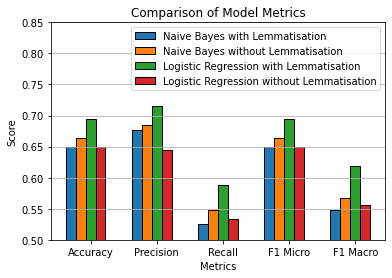

In [294]:
# define the different metrics and their scores for bayes with lem
metrics = ["Accuracy", "Precision", "Recall", "F1 Micro", "F1 Macro"]
bayes_lem = [acc_lem, prec_lem, rec_lem, f1_micro_lem, f1_macro_lem]

# define their scores for Bayes non lem
bayes_non_lem = [acc, prec, rec, f1_micro, f1_macro]

# Logistic Regresion with Lemmatisation
logi_lem = [acc_logi_lem, prec_logi_lem, rec_logi_lem, f1_micro_logi_lem, f1_macro_logi_lem]

# Logistic Regresion sans Lemmatisation
logi = [acc_logi, prec_logi, rec_logi, f1_micro_logi, f1_macro_logi]

# set the width of the bars
bar_width = 0.15

# set the x-positions of the bars
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# create the bar plot
plt.bar(r1, bayes_lem, color="tab:blue", width=bar_width, edgecolor="black", label="Naive Bayes with Lemmatisation")
plt.bar(r2, bayes_non_lem, color="tab:orange", width=bar_width, edgecolor="black", label="Naive Bayes without Lemmatisation")
plt.bar(r3, logi_lem, color="tab:green", width=bar_width, edgecolor="black", label="Logistic Regression with Lemmatisation")
plt.bar(r4, logi, color="tab:red", width=bar_width, edgecolor="black", label="Logistic Regression without Lemmatisation")

# add labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks([r + bar_width*2 for r in range(len(metrics))], metrics)
plt.title("Comparison of Model Metrics")

# set y-axis limits
plt.ylim(0.5, 0.85)

# add legend
plt.legend()

# show the plot
plt.grid(axis="y")
plt.savefig("model_comparison.png", dpi=300)
plt.show()